# 3D Forward Simulation of Airborne Time Domain Electromagnetic Data. 

In this notebook, we compute a single line of airborne electromagnetic (AEM) data over a conductive plate in a resistive background. We plot the currents and magnetic fields in the subsurface. 

This notebook generates Figures 1-4 in: 

Heagy, L., Kang, S., Cockett, R., and Oldenburg, D., 2018, _Open source software for simulations and inversions of airborne electromagnetic data_, AEM 2018 International Workshop on Airborne Electromagnetics 

- original from [simpeg-research/heagy-2018-AEM](https://github.com/simpeg-research/heagy-2018-AEM)

In [1]:
from SimPEG import EM, Mesh, Maps, Utils
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation, collections
from pymatsolver import Pardiso

import ipywidgets 
from IPython.display import HTML

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 16

## Create a Tensor Mesh

Here, we build a 3D Tensor mesh to run the forward simulation on. The mesh needs to extend far enough so that it is beyond the [diffusion distance](https://em.geosci.xyz/content/maxwell1_fundamentals/transient_planewaves_homogeneous/peakdistance.html) in the background host rock. 

Since we will only simulate 1 line of data, we will define the core region of the mesh to be along that line and will use padding cells (cells which expand with distance from the core region of the mesh) along the other dimension.

In [7]:
cs=50.  # cell width in m
ncx=20  # number of core cells (with size cs) in the x direction (along-line)
ncy=1  # number of core cells in the y direction (cross-line)
ncz=20  # number of core cells in the z direction
npad=10  # number of padding cells in each direction
pad_rate=1.3  # rate by which we expand the padding cells

# tensor description of cells in each dimension
hx = [(cs,npad,-pad_rate), (cs,ncx), (cs,npad,pad_rate)]  
hy = [(cs,npad,-pad_rate), (cs,ncy), (cs,npad,pad_rate)]
hz = [(cs,npad,-pad_rate), (cs,ncz), (cs,npad,pad_rate)]

# build the mesh object
mesh = Mesh.TensorMesh([hx,hy,hz], 'CCC')

The number of cells in the mesh controlls how computationally expensive the simulation is. 

In [5]:
print(f"The mesh has {mesh.nC} cells")

The mesh has 33600 cells


print diffusion distance and make sure mesh padding goes beyond that

In [9]:
from scipy.constants import mu_0
np.sqrt(2/mu_0)

1261.56626101008

In [11]:
def diffusion_distance(sigma, t):
    return 1260*np.sqrt(t/sigma)

print(
    "diffusion distance at 2.5ms in a 1e-3 S/m background"
    ": {:1.2e} m".format(diffusion_distance(1e-3, 2.5e-3))
)
print("print mesh extent : {:1.2e} m".format(mesh.hx[-10:].sum()))

diffusion distance at 2.5ms in a 1e-3 S/m background: 1.99e+03 m
print mesh extent : 2.77e+03 m


## Build a model

In [13]:
# conductivity values of the air, background and conductive plate
sig_air = 1e-8
sig_half = 1e-3
sig_plate = 1e-1

In [14]:
# put the model on the mesh 
block_x = [-50, 50]
block_y = [-500, 500]
block_z = [-450, -50]

blk_inds = (
    (mesh.gridCC[:, 0] >= block_x[0]) & (mesh.gridCC[:, 0] <= block_x[1]) &
    (mesh.gridCC[:, 1] >= block_y[0]) & (mesh.gridCC[:, 1] <= block_y[1]) &
    (mesh.gridCC[:, 2] >= block_z[0]) & (mesh.gridCC[:, 2] <= block_z[1])
)

# Utils.ModelBuilder.getIndicesBlock(
#     np.r_[-49.5, 500, -50],  # lower 
#     np.r_[50, -500, -450], 
#     mesh.gridCC
# )

sigma = np.ones(mesh.nC)*sig_air
sigma[mesh.gridCC[:,2]<0.] = sig_half
sigma_half = sigma.copy()
sigma[blk_inds] = sig_plate

In [17]:
# find the plane where we want to plot the model
xref = 0
zref = -100.
yref = 0.

xlim = [-700., 700.]
ylim = [-700., 700.]
zlim = [-700., 0.]

indx = int(np.argmin(abs(mesh.vectorCCx-xref)))
indy = int(np.argmin(abs(mesh.vectorCCy-yref)))
indz = int(np.argmin(abs(mesh.vectorCCz-zref)))

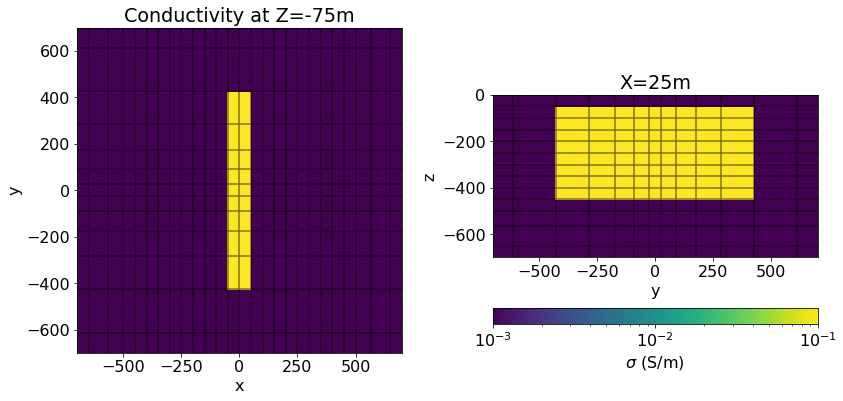

In [18]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

clim = [1e-3, 1e-1]

dat1 = mesh.plotSlice(sigma, grid=True, ax=ax[0], ind=indz, pcolorOpts={'norm':LogNorm()}, clim=clim)
dat2 = mesh.plotSlice(sigma, grid=True, ax=ax[1], ind=indx, normal='X', pcolorOpts={'norm':LogNorm()}, clim=clim)

cb = plt.colorbar(dat2[0], orientation="horizontal", ax = ax[1])

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim[0], 0.)

plt.tight_layout()

ax[0].set_aspect(1)
ax[1].set_aspect(1)

ax[0].set_title("Conductivity at Z={:1.0f}m".format(mesh.vectorCCz[indz]))
ax[1].set_title("X={:1.0f}m".format(mesh.vectorCCx[indx]))

cb.set_label("$\sigma$ (S/m)")

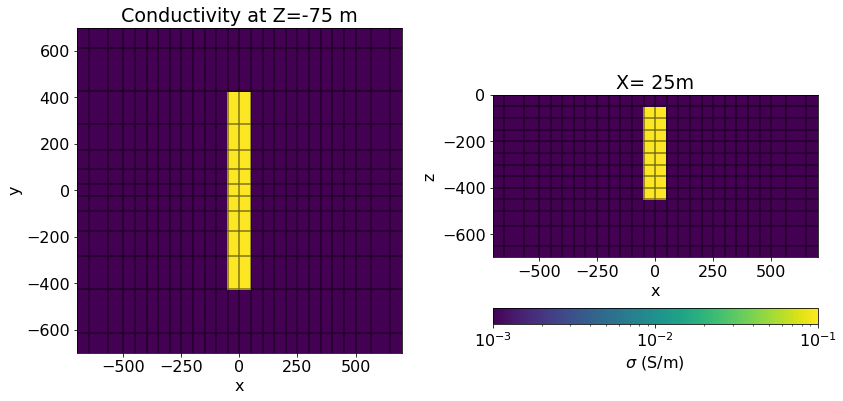

In [20]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))

clim = [1e-3, 1e-1]

dat1 = mesh.plotSlice(sigma, grid=True, ax=ax[0], ind=indz, pcolorOpts={'norm':LogNorm()}, clim=clim)
dat2 = mesh.plotSlice(sigma, grid=True, ax=ax[1], ind=indy, normal='Y', pcolorOpts={'norm':LogNorm()}, clim=clim)

cb = plt.colorbar(dat2[0], orientation="horizontal", ax = ax[1])

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_ylim(zlim)

plt.tight_layout()

ax[0].set_aspect(1)
ax[1].set_aspect(1)

ax[0].set_title("Conductivity at Z={:1.0f} m".format(mesh.vectorCCz[indz]))
ax[1].set_title("X= {:1.0f}m".format(mesh.vectorCCx[indx]))

cb.set_label("$\sigma$ (S/m)")


## Assemble the survey

In [23]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-450, mesh.vectorCCx<450)]


In [24]:
# assemble the sources and receivers
time = np.logspace(np.log10(5e-5), np.log10(2.5e-3), 21)
srcList = []

for xloc in x:
    location = np.array([[xloc, 0., 30.]])
    rx_z = EM.TDEM.Rx.Point_dbdt(location, time, 'z')
    rx_x = EM.TDEM.Rx.Point_dbdt(location, time, 'x')
    src = EM.TDEM.Src.CircularLoop([rx_z, rx_x], orientation='z', loc=location)
    srcList.append(src)

## Set up the forward simulation

In [25]:
timesteps = [(1e-05, 15), (5e-5, 10), (2e-4, 10)]

In [26]:
prb = EM.TDEM.Problem3D_b(mesh, Solver=Pardiso, verbose=True, timeSteps=timesteps, sigmaMap=Maps.IdentityMap(mesh))
survey = EM.TDEM.Survey(srcList)
survey.pair(prb)

## Solve the forward simulation

In [27]:
%%time
fields = prb.fields(sigma)

Calculating Initial fields
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-05)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 5.000000e-05)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...

# Compute the fields

In [28]:
def plot_currents(
    itime, iSrc, clim=None, ax=None, showcb=True, showit=True, 
    outline=True
):
    if ax is None: 
        fig, ax = plt.subplots(1,2, figsize = (16,8))
    
    location  = srcList[iSrc].loc
    S = np.kron(np.ones(3), sigma)
    j = Utils.sdiag(S) * mesh.aveE2CCV * fields[srcList[iSrc], 'e', itime]
    
    dat1 = mesh.plotSlice(
        j, normal='Z', ind=int(indz), vType='CCv', view='vec', ax=ax[0], 
        range_x=xlim, range_y=ylim, sample_grid = [cs, cs],
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    dat2 = mesh.plotSlice(
        j, normal='X', ind=int(indx), vType='CCv', view='vec', ax=ax[1], 
        range_x=xlim, range_y=zlim,
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'}, 
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    ax[0].plot(location[0], location[1], 'go', ms=20)
    ax[0].text(-600, 500, "Time: {:1.2f} ms".format(prb.times[itime]*1e3), color='w', fontsize=20)
    
    if showcb is True: 
        cb = plt.colorbar(dat1[0], orientation="horizontal", ax = ax[1])
        cb.set_label("Current density (A/m$^2$)")

    if outline is True: 
        ax[0].plot(
            np.r_[block_x, block_x[1], block_x[0], block_x[0]],
            np.r_[block_y[0], block_y, block_y[1], block_y[0]],
            'w'
        )

        ax[1].plot(
            np.r_[block_y, block_y[1], block_y[0], block_y[0]],
            np.r_[block_z[0], block_z, block_z[1], block_z[0]],
            'w'
        )
    
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    ax[0].set_title("Current density at Z={:1.0f}m".format(mesh.vectorCCz[indz]))
    ax[1].set_title("X={:1.0f}m".format(mesh.vectorCCx[indx]))
    
    
    if showit: 
        plt.show()
    
    return [d for d in dat1 + dat2]

## View the current density through time

In [29]:
ipywidgets.interact(
    plot_currents,
    itime = ipywidgets.IntSlider(min=1, max=len(prb.times), value=1),
    iSrc = ipywidgets.IntSlider(min=0, max=len(srcList), value=5),
    clim = ipywidgets.fixed([3e-13, 2e-9]),
    ax=ipywidgets.fixed(None), 
    showit=ipywidgets.fixed(True),
    showcb=ipywidgets.fixed(True), 
    outline=ipywidgets.fixed(True)
)


interactive(children=(IntSlider(value=1, description='itime', max=36, min=1), IntSlider(value=5, description='…

<function __main__.plot_currents(itime, iSrc, clim=None, ax=None, showcb=True, showit=True, outline=True)>

In [30]:
def plot_magnetic_flux(itime, iSrc, clim=None, ax=None, showcb=True, showit=True):
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    location  = srcList[iSrc].loc
    b = mesh.aveF2CCV * fields[survey.srcList[iSrc], 'b', itime]
    
    dat1 = mesh.plotSlice(
        b, normal='Y', ind=int(indy), vType='CCv', view='vec', 
        range_x=xlim, range_y=xlim,
        ax=ax, pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = clim[0] if clim is not None else None
    )

    ax.plot(location[0], location[2], 'go', ms=15)
    
    ax.text(-600, 500, "Time: {:1.2f} ms".format(prb.times[itime]*1e3), color='w', fontsize=20)
    
    # edges of the block
    ax.plot(
        np.r_[block_x, block_x[1], block_x[0], block_x[0]],
        np.r_[block_z[0], block_z, block_z[1], block_z[0]],
        'w'
    )
    
    if showcb: 
        cb = plt.colorbar(dat1[0], ax = ax)
        cb.set_label("Magnetic Flux Density (T)")
    ax.set_aspect(1)
    ax.set_title("Magnetic Flux Density at Y={:1.0f}m".format(mesh.vectorCCy[indy]))
    
    if showit: 
        plt.show()
    
    return [d for d in dat1 + dat2]

In [31]:
ipywidgets.interact(
    plot_magnetic_flux,
    itime = ipywidgets.IntSlider(min=1, max=len(prb.times)-1, value=1),
    iSrc = ipywidgets.IntSlider(min=0, max=len(srcList), value=5),
    clim = ipywidgets.fixed([1e-17, 3e-14]),
    ax=ipywidgets.fixed(None), 
    showit=ipywidgets.fixed(True),
    showcb=ipywidgets.fixed(True)
)


interactive(children=(IntSlider(value=1, description='itime', max=35, min=1), IntSlider(value=5, description='…

<function __main__.plot_magnetic_flux(itime, iSrc, clim=None, ax=None, showcb=True, showit=True)>

## Compute predicted data

In [32]:
dpred = survey.dpred(sigma, f=fields)
DPRED = dpred.reshape((survey.nSrc, 2, rx_z.times.size))

add noise to the data to create observed data

In [33]:
noise = abs(dpred)*0.05 * np.random.randn(dpred.size) + 1e-14
dobs = dpred + noise
DOBS = dobs.reshape((survey.nSrc, 2, rx_z.times.size))

In [34]:
# # uncomment to save
# np.save("dobs", dobs)
# np.save("dtrue", dpred)

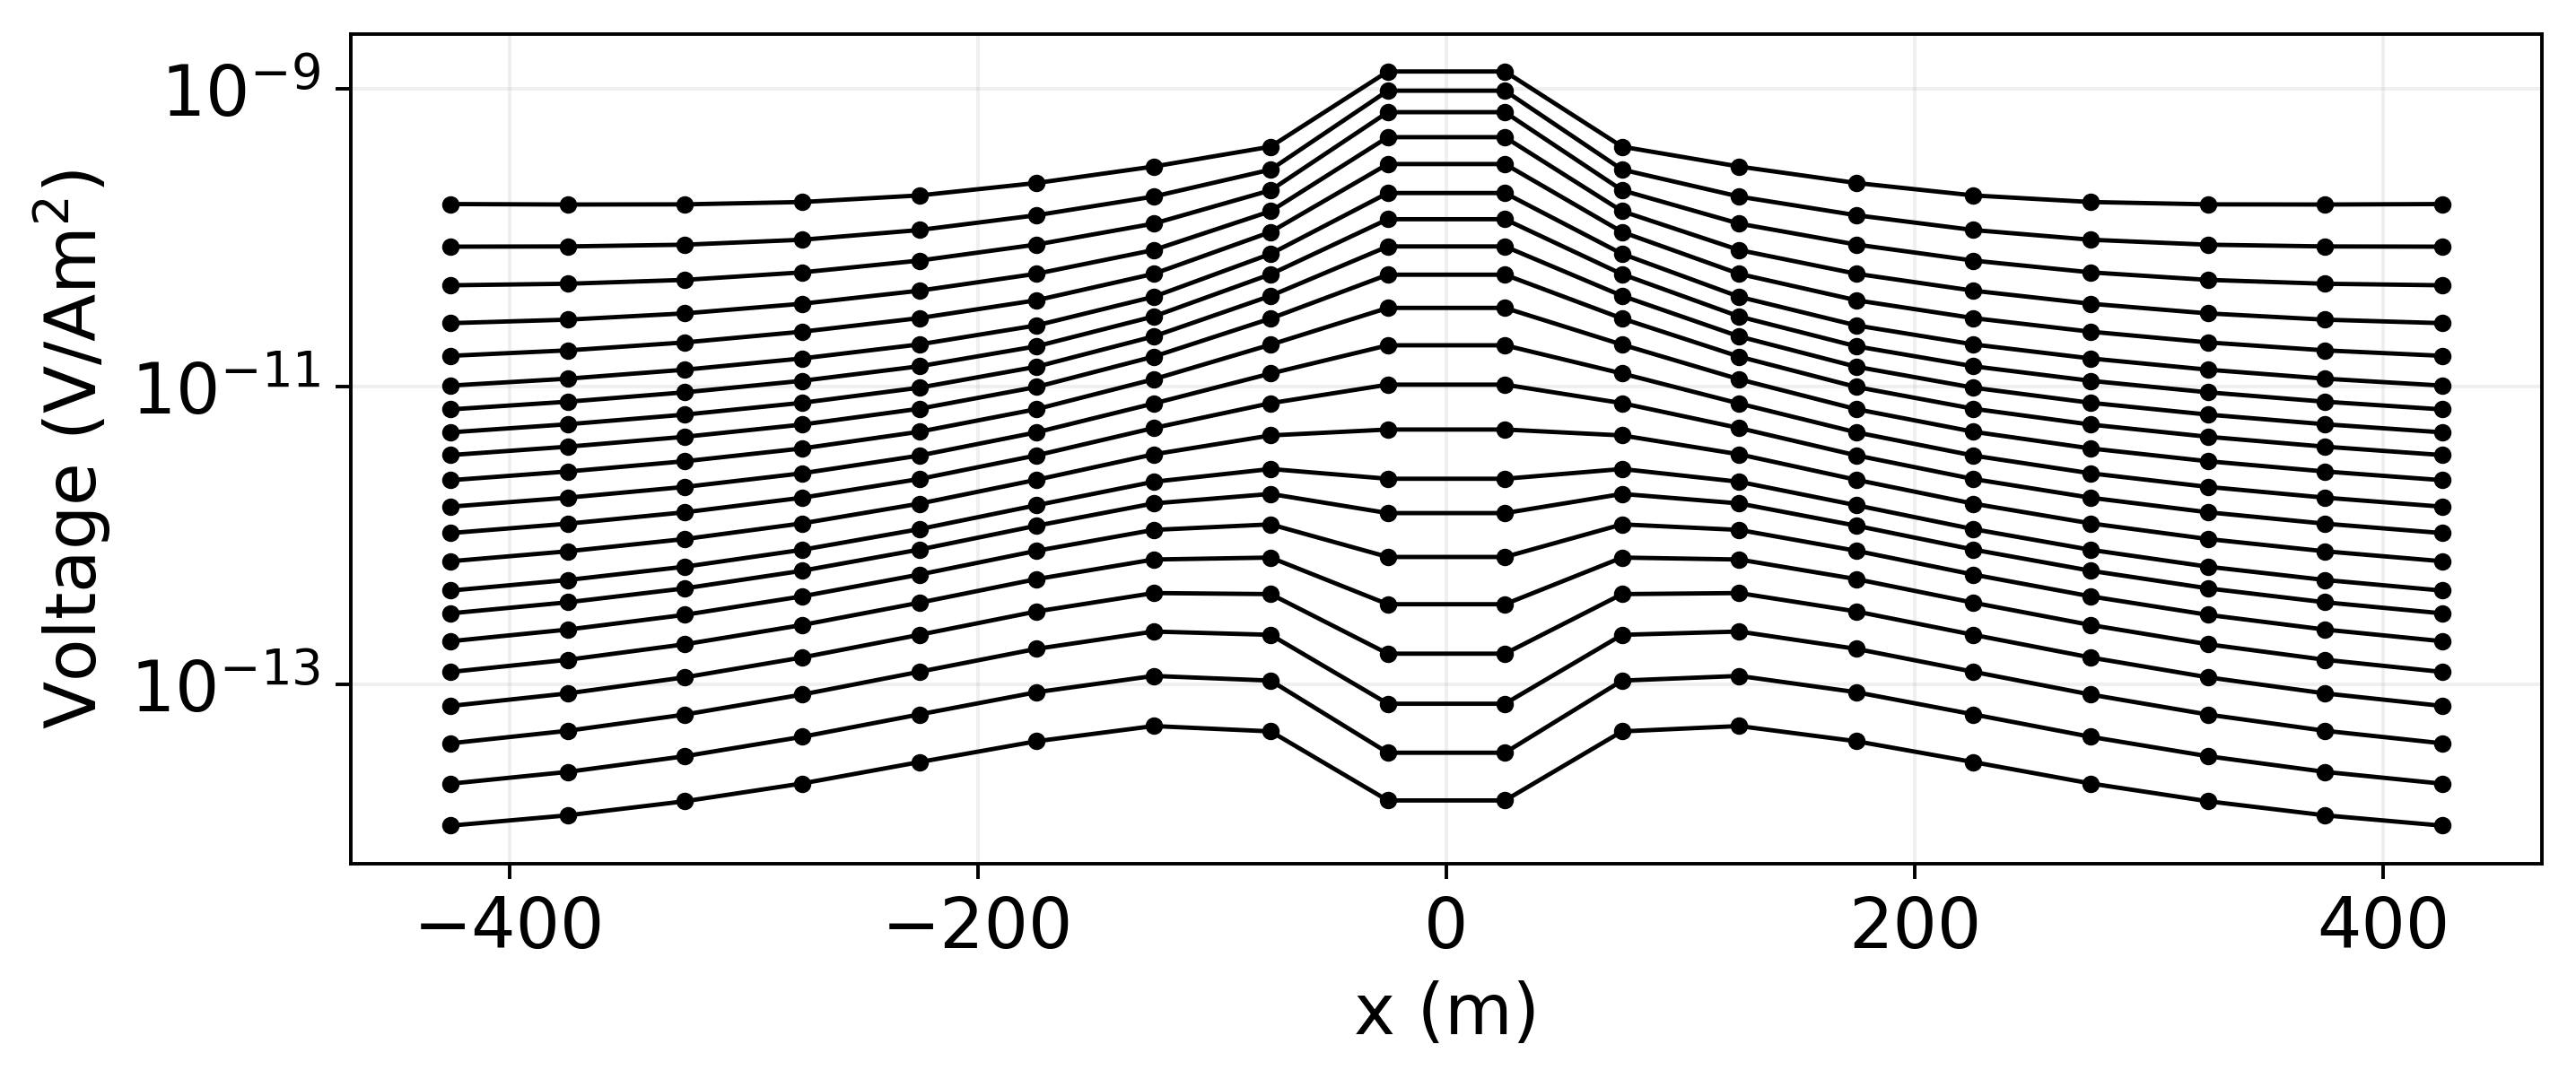

In [35]:
fig = plt.figure(figsize=(9, 3.5), dpi=350)
for itime in range(rx_z.times.size):
    plt.semilogy(x, -DPRED[:,0,itime], 'k.-', lw=1)
# plt.plot(srcList[5].loc[0]*np.ones(3), -DPRED[5,0,[0, 4, 12]] , 's', color="C3")
plt.xlabel("x (m)")
plt.ylabel("Voltage (V/Am$^2$)")
plt.grid(which="both", alpha=0.2)


## Print Figures

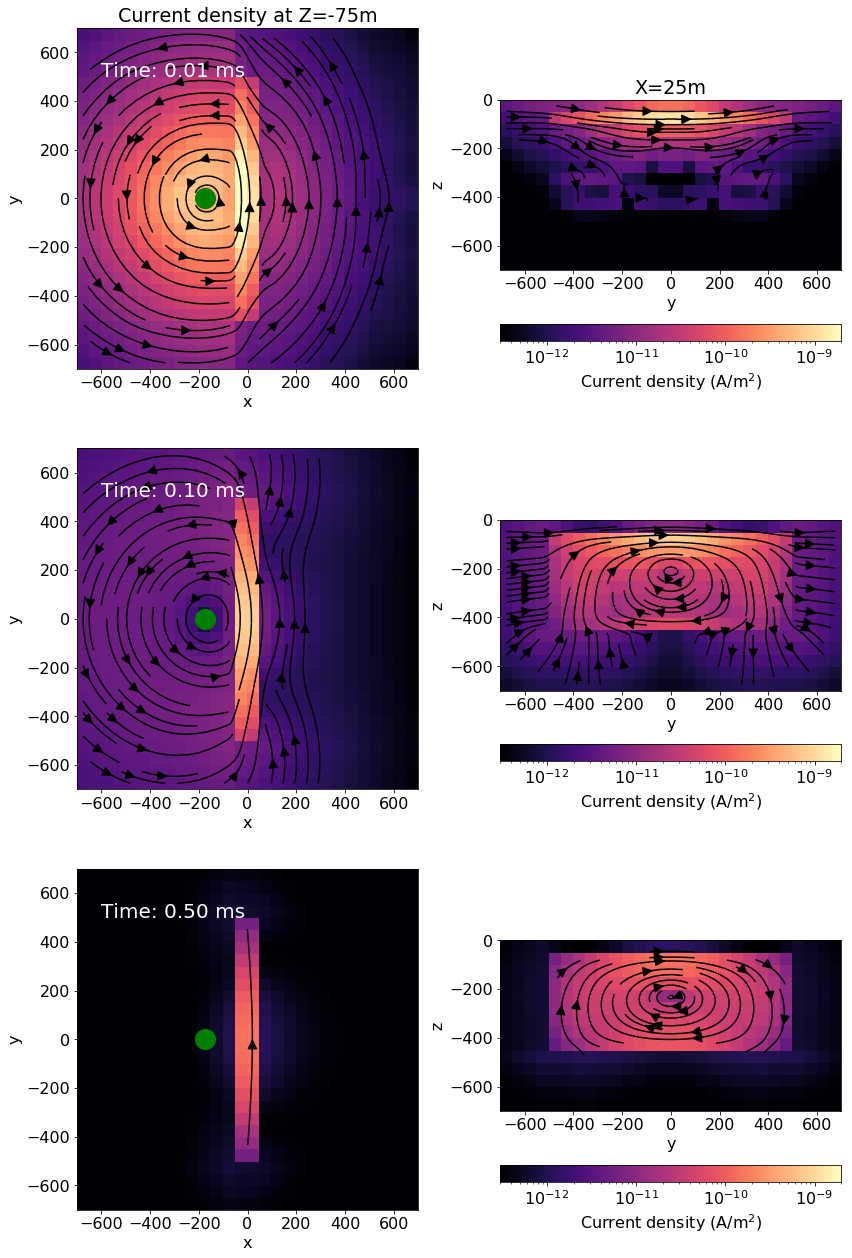

In [37]:
fig, axes = plt.subplots(3,2, figsize = (12,6*3))
 
iSrc = 5
clim = [3e-13, 2e-9]

for i, itime in enumerate([1, 10, 22]):
    
    ax = axes[i, :]
    location  = srcList[iSrc].loc
    
    S = np.kron(np.ones(3), sigma)
    j = Utils.sdiag(S) * mesh.aveE2CCV * fields[srcList[iSrc], 'e', itime]

    dat1 = mesh.plotSlice(
        j, normal='Z', ind=int(indz), vType='CCv', view='vec', ax=ax[0], 
        range_x=xlim, range_y=ylim, 
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    dat2 = mesh.plotSlice(
        j, normal='X', ind=int(indx), vType='CCv', view='vec', ax=ax[1], 
        range_x=xlim, range_y=zlim,
        pcolorOpts={'norm':LogNorm(), 'cmap':'magma'}, 
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = 1e-12 if clim is not None else None
    )
    
    ax[0].plot(location[0], location[1], 'go', ms=20)
    ax[0].text(-600, 500, "Time: {:1.2f} ms".format(prb.times[itime]*1e3), color='w', fontsize=20)
    cb = plt.colorbar(dat1[0], orientation="horizontal", ax = ax[1])
    cb.set_label("Current density (A/m$^2$)")
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    
    
    if itime == 1: 
        ax[0].set_title("Current density at Z={:1.0f}m".format(mesh.vectorCCz[indz]))
        ax[1].set_title("X={:1.0f}m".format(mesh.vectorCCx[indx]))
    else:
        ax[0].set_title("")
        ax[1].set_title("")

plt.tight_layout()
plt.show()


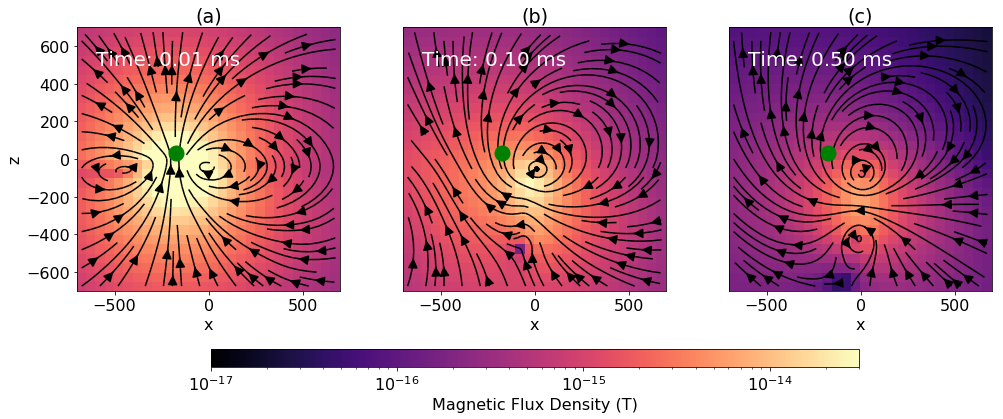

In [38]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))

fig.subplots_adjust(bottom=0.7)

iSrc = 5
clim = [1e-17, 3e-14]

for a, itime, title in zip(ax, [1, 10, 22], ["a", "b", "c"]):
    location  = srcList[iSrc].loc
    
    b = mesh.aveF2CCV * fields[survey.srcList[iSrc], 'b', itime]
    
    dat1 = mesh.plotSlice(
        b, normal='Y', ind=int(indy), vType='CCv', view='vec', 
        range_x=xlim, range_y=xlim,
        ax=a, pcolorOpts={'norm':LogNorm(), 'cmap':'magma'},
        streamOpts={'arrowsize':2, 'color':'k'},
        clim=clim, stream_threshold = clim[0] if clim is not None else None
    )
        
    if itime > 1:
        a.get_yaxis().set_visible(False)

    a.plot(location[0], location[2], 'go', ms=15)
    
    a.text(-600, 500, "Time: {:1.2f} ms".format(prb.times[itime]*1e3), color='w', fontsize=20)
    a.set_aspect(1)
    a.set_title("({})".format(title))
#     a.set_title(("Magnetic Flux Density at Y=%.0fm")%(mesh_core.vectorCCy[indy]))
    

plt.tight_layout()


cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
cb = fig.colorbar(dat1[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic Flux Density (T)')